In [1]:
from IPT import Particle, ParticleSystem, RK4, f
import numpy as np
import matplotlib.pyplot as plt
import ase.data

atomic_masses = { k: ase.data.atomic_masses[v] 
                 for k,v in ase.data.atomic_numbers.items() }
print(atomic_masses)

{'X': 1.0, 'H': 1.008, 'He': 4.002602, 'Li': 6.94, 'Be': 9.0121831, 'B': 10.81, 'C': 12.011, 'N': 14.007, 'O': 15.999, 'F': 18.998403163, 'Ne': 20.1797, 'Na': 22.98976928, 'Mg': 24.305, 'Al': 26.9815385, 'Si': 28.085, 'P': 30.973761998, 'S': 32.06, 'Cl': 35.45, 'Ar': 39.948, 'K': 39.0983, 'Ca': 40.078, 'Sc': 44.955908, 'Ti': 47.867, 'V': 50.9415, 'Cr': 51.9961, 'Mn': 54.938044, 'Fe': 55.845, 'Co': 58.933194, 'Ni': 58.6934, 'Cu': 63.546, 'Zn': 65.38, 'Ga': 69.723, 'Ge': 72.63, 'As': 74.921595, 'Se': 78.971, 'Br': 79.904, 'Kr': 83.798, 'Rb': 85.4678, 'Sr': 87.62, 'Y': 88.90584, 'Zr': 91.224, 'Nb': 92.90637, 'Mo': 95.95, 'Tc': 97.90721, 'Ru': 101.07, 'Rh': 102.9055, 'Pd': 106.42, 'Ag': 107.8682, 'Cd': 112.414, 'In': 114.818, 'Sn': 118.71, 'Sb': 121.76, 'Te': 127.6, 'I': 126.90447, 'Xe': 131.293, 'Cs': 132.90545196, 'Ba': 137.327, 'La': 138.90547, 'Ce': 140.116, 'Pr': 140.90766, 'Nd': 144.242, 'Pm': 144.91276, 'Sm': 150.36, 'Eu': 151.964, 'Gd': 157.25, 'Tb': 158.92535, 'Dy': 162.5, 'Ho': 1

This notebook checks that the IPT works properly via some sanity plots

1) Visually confirming: the circular motion expected in a uniform magnetic field
2) radius of curvature 
3)





In [11]:
#plotlib params
plt.rcParams.update({
             'axes.labelsize': 18,
             'axes.titlesize': 20,
             'xtick.labelsize': 16,
             'ytick.labelsize': 16,
             'axes.linewidth': 0.5,
             'legend.fontsize': 16,
             'legend.title_fontsize': 18,
             'axes.titlepad': 10,
                            })

In [12]:
# setting constants 
mp=1.672621e-27 # mass proton, [mp]=kg
mn=1.674927e-27 # mass neutron, [mn]=kg
me=9.109382e-31 # mass electron, [me]=kg
m_amu=1.660539e-27 # Dalton, [m_amu]=kg
qe=1.602176e-19 # elementary charge, [qe]=C
kB=1.380e-23
###

In [13]:
#  example: char temp in outer edge is ~10eV
# tungsten atom
ms=atomic_masses["W"]*m_amu
T_char_eV=1e1 # eV
T_char_K=(kB/qe)**-1*T_char_eV # 1e4 K/eV so about 1e5 K in edge 


def omega_cs(qs,B,ms):
    # q charge in integer (integers elementary charge)
    # B in tesla
    # ms in kg
    q=qs*qe
    return abs(q)*B/ms

def tau_cs(qs,B,ms):
    return (omega_cs(qs,B,ms)/(2*np.pi))**-1

def vth(T_eV,ms):
    # T in eV -> T in J
    return (3/2*2*(T_eV*qe)/ms)**0.5


print(f"Temperature is T={T_char_eV:.2f} eV = {T_char_K:.2e} K")

print(f"speed is {vth(T_char_eV,ms):.2e} m/s")

print(f"cyclotron period {tau_cs(1,1,ms):.2e} s")

Temperature is T=10.00 eV = 1.16e+05 K
speed is 3.97e+03 m/s
cyclotron period 1.20e-05 s


In [14]:
p1=Particle('W',[1.0,0,0],[1,1,1])
model=f(B_choice=0,B_R0=1.0)


#### velocities and forces felt at initial position #### 
model.calculate(particle=p1,dt=0,dy=[0,0,0,0,0,0])


array([[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        -5.24832995e+05,  0.00000000e+00,  5.24832995e+05]])

In [25]:
B_char=1

p1=Particle('W',position=[0,0,0],velocity=[1,1e3,0])
sys1=ParticleSystem([p1])
model=f(B_choice=0,B_R0=B_char,R0=1)
# model.calculate(p1,0,[0,0,0,0,0,0]) # if want to see accel and vel at init

### timestep choice
ms=atomic_masses['W']*m_amu
qs=1

N_dt=100
dt=tau_cs(qs,B_char,ms)/N_dt
#
print(tau_cs(qs,B_char,ms))
dt=tau_cs(qs,B_char,ms)/N_dt
print(dt)
###

# setting the model
dyn=RK4(sys1,model=model,timestep=dt)
# works with just 1 Particle also


# using same dt, particle, model etc as before
N_loop=99 # how many loops
N_i=1 # number of calc in each loop
N_tot=N_loop*N_i # total calculations inside loop

#### run simulation

## initialize 
r_ex1=[]
v_ex1=[]
# init pos & vel 
r_ex1.append(sys1.get_positions().reshape(3,))
v_ex1.append(sys1.get_velocities().reshape(3,))
# r,v wil be (N_tot+1 , 3)  dimensional

for i in range(N_loop):
    dyn.run(N_i)
    r_ex1.append(sys1.get_positions().reshape(3,)) # reshape from (1,3) -> (3,)
    v_ex1.append(sys1.get_velocities().reshape(3,))

r_ex1=np.array(r_ex1)
v_ex1=np.array(v_ex1)


1.197178028837949e-05
1.197178028837949e-07


Text(0.5, 1.0, 'W Particle for 0.99 gyro periods')

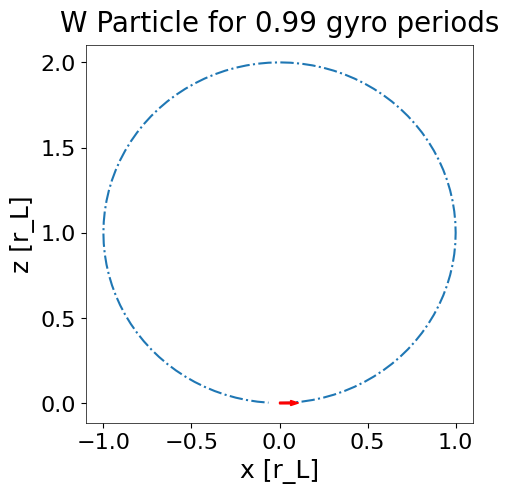

In [26]:
x0,y0,z0=r_ex1[0,:]
# x0=0
r_L=(np.sum(v_ex1[0,[0,2]]**2))**0.5/omega_cs(qs,B_char,ms)

plt.figure(figsize=(5,5),dpi=100)
plt.plot((r_ex1[:,0]-x0)/r_L,(r_ex1[:,2]-z0)/r_L,'-.')
plt.arrow((r_ex1[0,0]-x0)/r_L,(r_ex1[0,2]-z0)/r_L,v_ex1[0,0]*dt/r_L,v_ex1[0,2]*dt/r_L,width=0.01,color="red",zorder=10)
plt.plot()
# plt.xlim([-0.1,2.1])
# plt.ylim([-1.1,1.1])
plt.xlabel("x [r_L]")
plt.ylabel("z [r_L]")
plt.title(f"W Particle for {(N_tot/N_dt):.2f} gyro periods")



In [29]:
B_char=1

p1=Particle('W',position=[0,0,0],velocity=[1,1e3,0])
sys1=ParticleSystem([p1])
model=f(B_choice=0,B_R0=B_char,R0=1)
# model.calculate(p1,0,[0,0,0,0,0,0]) # if want to see accel and vel at init

### timestep choice
ms=atomic_masses['W']*m_amu
qs=1

N_dt=100
dt=tau_cs(qs,B_char,ms)/N_dt
#
print(tau_cs(qs,B_char,ms))
dt=tau_cs(qs,B_char,ms)/N_dt
print(dt)
###

# setting the model
dyn=RK4(sys1,model=model,timestep=dt)
# works with just 1 Particle also


# using same dt, particle, model etc as before
N_loop=99 # how many loops
N_i=1 # number of calc in each loop
N_tot=N_loop*N_i # total calculations inside loop

#### run simulation

## initialize 
r_ex1=[]
v_ex1=[]
# init pos & vel 
r_ex1.append(sys1.get_positions().reshape(3,))
v_ex1.append(sys1.get_velocities().reshape(3,))
# r,v wil be (N_tot+1 , 3)  dimensional

for i in range(N_loop):
    dyn.run(N_i)
    r_ex1.append(sys1.get_positions().reshape(3,)) # reshape from (1,3) -> (3,)
    v_ex1.append(sys1.get_velocities().reshape(3,))

r_ex1=np.array(r_ex1)
v_ex1=np.array(v_ex1)

1.197178028837949e-05
1.197178028837949e-07


In [33]:

x=r_ex1[:,0]
y=r_ex1[:,1]
z=r_ex1[:,2]


zx=np.gradient(z,x) # numerical gradient

zxx=np.gradient(zx,x) # 2nd numerical gradient

# there is a problem with numerical gradient in a circular motion, will blow up at right and left parts of circle
# and go toward zero upper and lower parts

R=(1+zx**2)**(3/2)/zxx # radius of curvature
# very close to larmor radius

# remove worst outliers 
mask1=(np.quantile(R,0.1)< R)*(R<np.quantile(R,0.9))
mask2=(np.quantile(R,0.4)<R)*(np.quantile(R,0.6)>R)
mask3=mask2!=1 # we want to exclude them

mask=mask1*mask3 # when they both agree i.e.  R in [0.1:0.4] and [0.6:0.9]

print(sum(mask)) # removed 40% of pts 
print(len(R))

tangent_orthogonal=np.array([-zx[mask],np.ones(len(-zx[mask]))]) # 90 deg to tangent -> direction toward center of circle

e_RCurv=tangent_orthogonal/np.linalg.norm(tangent_orthogonal,axis=0) # unit vector in direction of the center 

r_center=np.array([x,z])[:,mask]+e_RCurv*R[mask] # center position (x,z)

x0,y0,z0=r_ex1[0,:]
# x0=0
r_L=(np.sum(v_ex1[0,[0,2]]**2))**0.5/omega_cs(qs,B_char,ms)


60
100


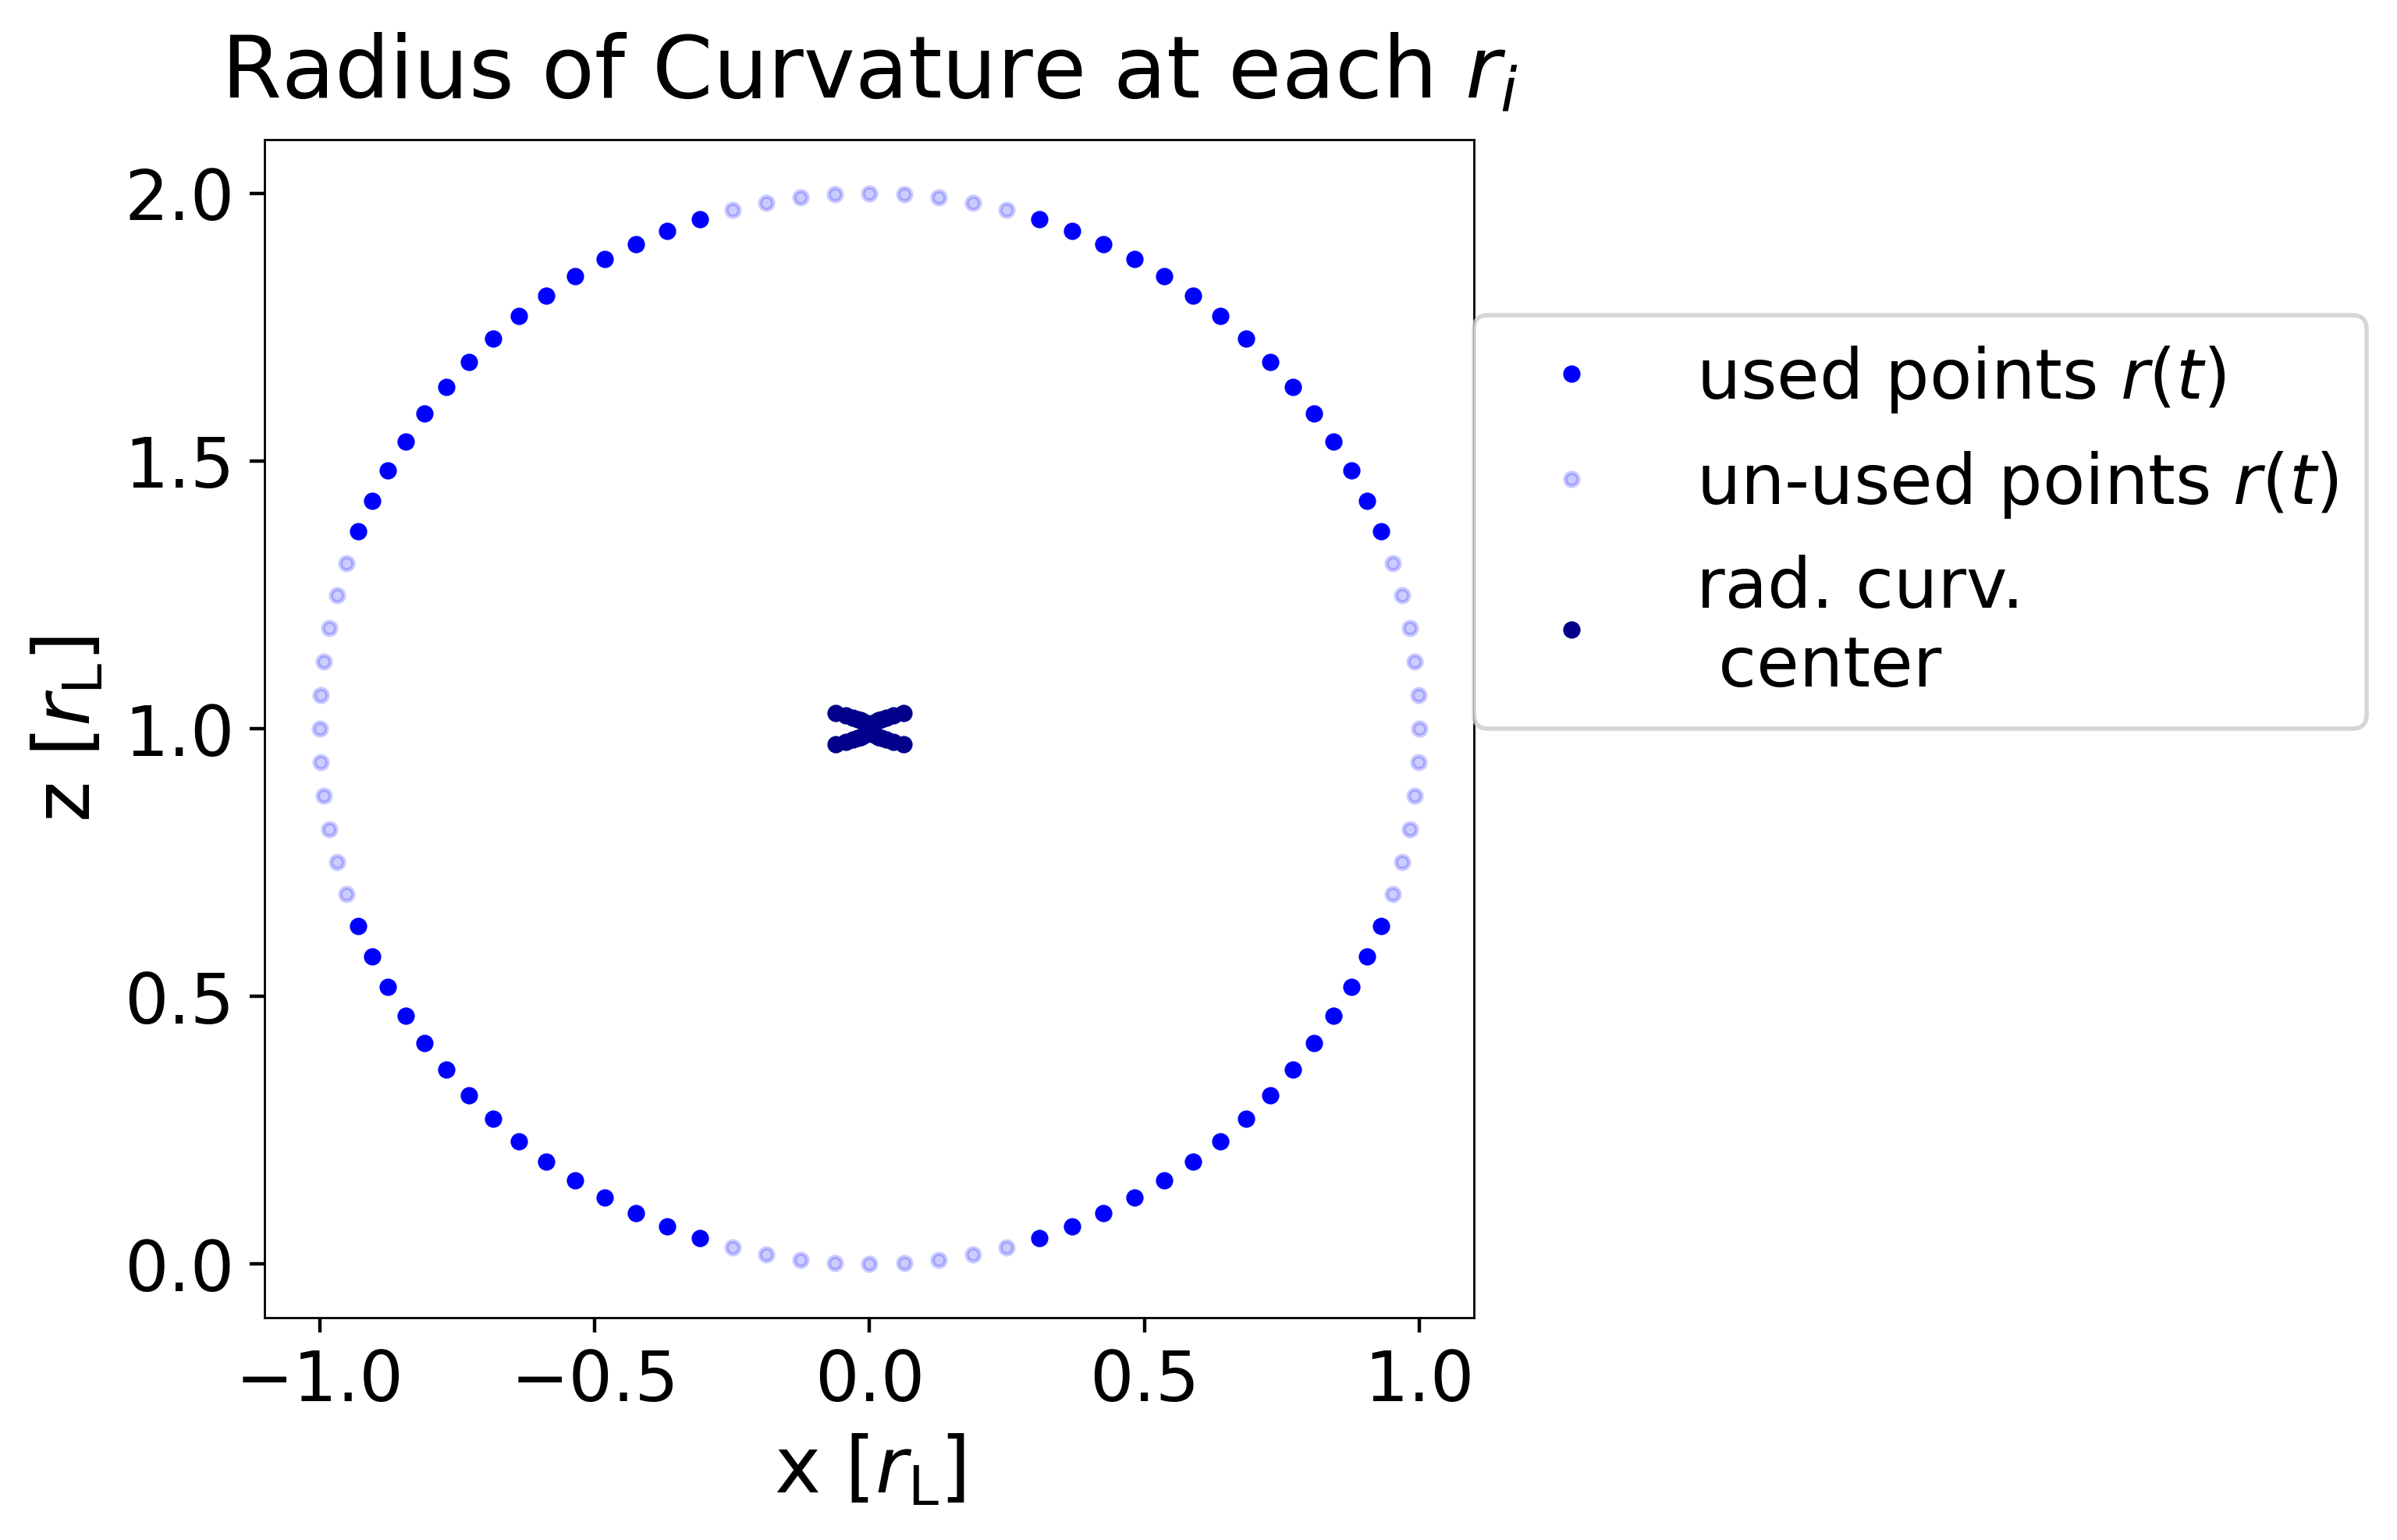

In [35]:

plt.figure(figsize=(5,5),dpi=400)
plt.plot(x[mask]/r_L,z[mask]/r_L,'.',color="blue",label="used points"+ r" $r(t)$")
plt.plot(x[mask!=1]/r_L,z[mask!=1]/r_L,'.',color="blue",alpha=0.2,label=r"un-used points $r(t)$")
plt.plot(r_center[0,:]/r_L,r_center[1,:]/r_L,'.',color="darkblue",label="rad. curv. \n center")

plt.xlabel(r"x [$r_\mathrm{L}$]")
plt.ylabel(r"z [$r_\mathrm{L}$]")
plt.title(r"Radius of Curvature at each $r_i$")
plt.legend(loc=[1,0.5])
# plt.savefig("rad_curv_one_Larmor.pdf",bbox_inches="tight")


In [41]:
np.mean(r_center,axis=1)/r_L -np.array([0,1]) # error is very low

array([ 1.59171768e-10, -5.93131233e-09])

**Now we test using a gradB**

In [42]:
B_char=1

p1=Particle('W',position=[1,0,0],velocity=[1e4,1e3,0]) # so will feel 1T at center
sys1=ParticleSystem([p1])
model=f(B_choice=2,B_R0=B_char,R0=1) #B_choice = 2 - so now a gradB

### timestep choice
ms=atomic_masses['W']*m_amu
qs=1

N_dt=100 
dt=tau_cs(qs,B_char,ms)/N_dt
#
print(tau_cs(qs,B_char,ms))
dt=tau_cs(qs,B_char,ms)/N_dt
print(dt)
###

# setting the model
dyn=RK4(sys1,model=model,timestep=dt)

# ~5 gyroperiods, but now gyroperiod depends on location because: B(x) => tau_c(x)
# using same dt, particle, model etc as before
N_loop=600 # how many loops
N_i=1 # number of calc in each loop
N_tot=N_loop*N_i # total calculations inside loop

#### run simulation

## initialize 
r_ex1=[]
v_ex1=[]
# init pos & vel 
r_ex1.append(sys1.get_positions().reshape(3,))
v_ex1.append(sys1.get_velocities().reshape(3,))
# r,v wil be (N_tot+1 , 3)  dimensional

for i in range(N_loop):
    dyn.run(N_i)
    r_ex1.append(sys1.get_positions().reshape(3,)) # reshape from (1,3) -> (3,)
    v_ex1.append(sys1.get_velocities().reshape(3,))

r_ex1=np.array(r_ex1)
v_ex1=np.array(v_ex1)

1.197178028837949e-05
1.197178028837949e-07


In [48]:
x=r_ex1[:,0]
y=r_ex1[:,1]
z=r_ex1[:,2]

zx=np.gradient(z,x)

zxx=np.gradient(zx,x)

mask=(np.quantile(zx,0.2)<zx)*(zx<np.quantile(zx,0.8))

mask[0:2]=0 # 2 init points removed
mask[[-2,-1]]=0 # last points removed

zx[mask]

R=(1+zx**2)**(3/2)/zxx # rad of curvature, close to larmor radius

print(sum(mask)) # removed about 40% of pts + the 2 at the boundaries
print(len(R))

tangent_orthogonal=np.array([-zx[mask],np.ones(len(-zx[mask]))])

e_RCurv=tangent_orthogonal/np.linalg.norm(tangent_orthogonal,axis=0) # unit vector in direction of the center 

r_center=np.array([x,z])[:,mask]+e_RCurv*R[mask] # center position (x,z)

x0,y0,z0=r_ex1[0,:]
r_L=(np.sum(v_ex1[0,[0,2]]**2))**0.5/omega_cs(qs,B_char,ms) # r_L at init


355
601
0.5906821963394343


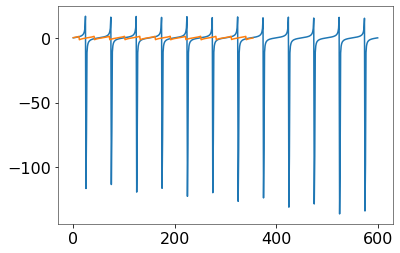

In [49]:
# why there is a mask: try to remove the blowing up of numerical gradient
plt.plot(zx)
plt.plot(zx[mask]) 

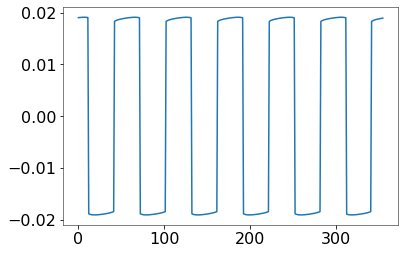

In [52]:
plt.plot(R[mask])

0.35426772428162634
0.3591534086513847


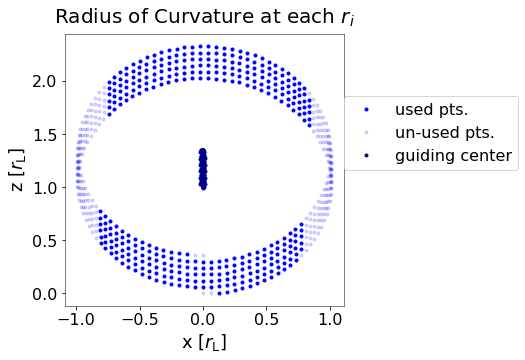

In [54]:
gc_larmor=(r_center-np.array([x0,z0]).reshape(2,1))/r_L
vperp=(np.sum(v_ex1[:,[0,2]]**2,axis=1))**0.5

plt.figure(figsize=(5,5))
# plt.plot((x-x0)/r_L,(z-z0)/r_L,'.',zorder=1,color="blue")
plt.plot((x[mask]-x0)/r_L,z[mask]/r_L,'.',color="blue",label="used pts.")
plt.plot((x[mask!=1]-x0)/r_L,z[mask!=1]/r_L,'.',color="blue",alpha=0.15,label="un-used pts.")
plt.plot(gc_larmor[0,:],gc_larmor[1,:],'.',color="darkblue", label="guiding center")

# - we don't care about mean value here - bec we want how much it moves
print(gc_larmor[1,-1]-gc_larmor[1,0]) # ~.3542 r_L in z direction. # matches well with plot, looking by eye

BR0=1 # 1T at x=1 - use as estimate 
gradB=-1
mu=(vperp**2*ms)/(2*BR0)
v_gradB=-mu[0]*gradB/(qs*qe*BR0)

# print(v_gradB)
dz_analytical=v_gradB/r_L*N_tot*dt
print(v_gradB/r_L*N_tot*dt)


plt.xlabel(r"x [$r_\mathrm{L}$]")
plt.ylabel(r"z [$r_\mathrm{L}$]")
plt.title(r"Radius of Curvature at each $r_i$")
plt.legend(loc=[1,0.5])
# plt.savefig("rad_curv_5_Larmor.pdf",bbox_inches="tight")


In [46]:
# print(v_gradB)
dz_analytical=v_gradB/r_L*N_tot*dt
print(dz_analytical)
print(gc_larmor[1,-1]-gc_larmor[1,0])

0.3555618745648708
0.35426772428162634


In [82]:
((np.array([x,z])[:,mask][:,-1])-np.array([x0,z0]))/r_L

array([-0.12873134,  0.36749718])

0.019053680105057123

In [ ]:
# so it has moved about 1 r_L up